In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

2025-02-28 12:07:14.117903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 12:07:14.347304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740724634.430437   16367 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740724634.454819   16367 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 12:07:14.732840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# WandB Log-in
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: venkatesh19v (venkatesh19v-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# Initialize the project in WandB
wandb.init(project="test-project",
    notes="This is Assignment 1 for the course DA6401", 
    tags=["assignment_1", "fashion_mnist"])

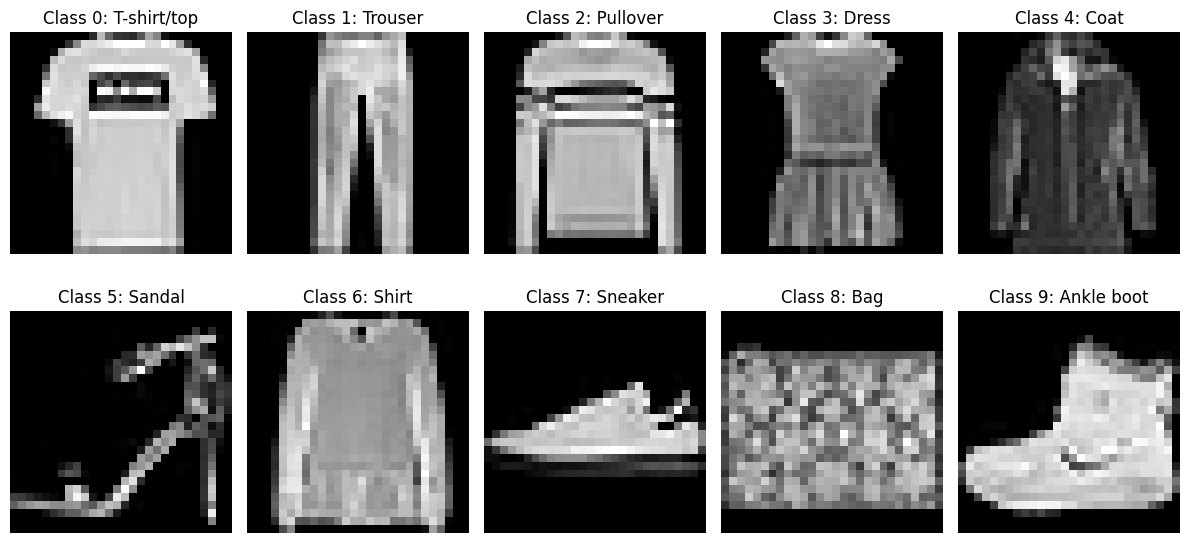

In [4]:
# Loading fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Class names for f-MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Dictionary to store one sample image for each class
sample_images = {}

# Iterating training data to collect one image per class
for img, label in zip(X_train, y_train):
    if label not in sample_images:
        sample_images[label] = img
    # Image for every class (0-9)
    if len(sample_images) == 10:
        break

# Create a grid plot (2 rows x 5 columns) to display the images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(sample_images[i], cmap='gray')
    axes[i].set_title(f"Class {i}: {class_names[i]}")
    axes[i].axis('off')

plt.tight_layout()

# Log the plot to wandb
wandb.log({"Sample Images": [wandb.Image(fig, caption=class_names[i])]})

plt.show()

# Finish the wandb run
wandb.finish()


In [7]:
def relu(x):
    # ReLU: f(x) = max(0,x) (0 to +ve infinite) 
    relu = np.maximum(0, x)
    return relu

def relu_derivative(x):
    # ReLU Derivative: f(x)= {0 if x<0; 1 if x>0}  | (0. to 1.)
    relu_derivative = (x > 0).astype(float) 
    return relu_derivative

def sigmoid(x):
    # Sigmoid: f(x) = 1 / (1 + e^(-x)) | (0 to 1)
    sigmoid = 1 / (1 + np.exp(-x))
    return sigmoid

def sigmoid_derivative(x):
    # Sigmoid Derivative: f(x) = 1 / (1 + e^(-x)) * (1 - f(x)) | (0 to +ve infinite)
    sig = sigmoid(x)
    sigmoid_derivative = sig * (1 - sig)
    return sigmoid_derivative

def tanh(x):
    # Tanh: f(x) = (e^x - e^(-x)) / (e^x + e^(-x)) | (-1 to 1)
    tanh = np.tanh(x)
    return tanh

def tanh_derivative(x):
    # Tanh Derivative: f(x) = 1 - f(x)^2 | (0 to 1) 
    tanh_derivative = 1 - np.tanh(x)**2
    return tanh_derivative

def softmax(x):
    # Softmax: f(x) = e^(x - max(x)) / sum(e^(x - max(x))) | (0 to 1)
    ex_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    soft_max = ex_x / np.sum(ex_x, axis=1, keepdims=True)
    return soft_max

In [ ]:
# FeedForward Neural Network class
class FeedForwardNN:
    # Initializing Constructor
    def __init__(self, input_size, hidden_layers, output_size, activation='relu', weight_init='random'):
        self.activation_name = activation
        if activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        elif activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_derivative = tanh_derivative
        else:
            raise ValueError("Unsupported activation function.")
        
        # Layer sizes and Initialize parameters
        self.layer_sizes = [input_size] + hidden_layers + [output_size]
        self.weights = []
        self.biases = []
        for i in range(len(self.layer_sizes) - 1):
            if weight_init == "random":
                W = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * 0.01
            elif weight_init == "xavier":
                W = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(1.0 / self.layer_sizes[i])
            else:
                print(f"Invalid weight_init: {weight_init}")
                raise ValueError("Unsupported weight initialization method.")

            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)
    
    def forward(self, X):
        """
        Performs a forward pass and caches intermediate activations and linear transforms.
        Returns the output and a cache dictionary.
        Pre-activation values (Z): 
        (a -> Z, h -> A)
        Linear transformation at each layer : ai(x)=Wi hi-1(x)+bi

        Activations (A): 
        After applying the activation function : hi(x) = g(ai(x)) 
        """
        cache = {"A": [], "Z": []}
        A = X
        cache["A"].append(A)  # A0 = input
        
        # Hidden layers
        for i in range(len(self.weights) - 1):
            """
            Z[i]=A[i-1]W[i]+b[i]
            Z[i] is the linear transformation (input to activation) at layer i,
            A[i-1] is the output of the previous layer,
            W and be are weights and biases for layer i.
            """
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            cache["Z"].append(Z)
            A = self.activation(Z)
            cache["A"].append(A)
        
        # Output layer with softmax activation function
        Z = np.dot(A, self.weights[-1]) + self.biases[-1]
        cache["Z"].append(Z)
        A = softmax(Z)
        cache["A"].append(A)
        return A, cache

    def compute_loss(self, Y_pred, Y_true):
        """
        Computes cross-entropy loss.
        
        m is the number of examples,
        Y_true is the one-hot encoded vector of true labels for the i-th example,
        Y_pred is the predicted probability distribution of the i-th example.
        """
        m = Y_true.shape[0]
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
        return loss
    
    def compute_accuracy(self, Y_pred, Y_true):
        # Computes the accuracy of the model.

        predictions = np.argmax(Y_pred, axis=1)
        labels = np.argmax(Y_true, axis=1)
        return np.mean(predictions == labels)


    def backward(self, X, Y_true, cache):
        """
        Performs backpropagation to compute gradients for weights and biases.
        Returns lists of gradients for weights and biases.
        """
        m = X.shape[0]
        L = len(self.weights)  # Total number of layers
        grads_W = [None] * L
        grads_b = [None] * L

        # Output layer gradient
        A_final = cache["A"][-1]
        dZ = A_final - Y_true  # derivative for softmax + cross entropy (output layer)
        grads_W[L - 1] = np.dot(cache["A"][-2].T, dZ) / m # dW = A_prev * dZ/m (gradient of weights)
        grads_b[L - 1] = np.sum(dZ, axis=0, keepdims=True) / m # db = dZ/m (gradient of biases)

        # Backpropagate through hidden layers
        for i in range(L-2, -1, -1):
            dA = np.dot(dZ, self.weights[i + 1].T)
            Z = cache["Z"][i]
            dZ = dA * self.activation_derivative(Z)
            grads_W[i] = np.dot(cache["A"][i].T, dZ) / m
            grads_b[i] = np.sum(dZ, axis=0, keepdims=True) / m

        return grads_W, grads_b

    def update_parameters(self, grads_W, grads_b, optimizer):
        """
        Combines weights and biases into a single list, updates them using the provided optimizer,
        and then splits them back into weights and biases.

        W[i]=W[i]-η⋅∂Loss/∂W[i]
        """
        # Combine parameters and gradients into one list each.
        params = self.weights + self.biases
        grads = grads_W + grads_b

        # Use the optimizer to update the parameters in place.
        updated_params = optimizer.update(params, grads)

        # Split updated_params back into weights and biases.
        L = len(self.weights)
        self.weights = updated_params[:L]
        self.biases = updated_params[L:]

In [8]:
class Optimizer:
    """
    Base Optimizer class that outlines the interface for optimization algorithms.
    params (list): List of model parameters (weights and biases).
    grads (list): List of gradients with respect to the model parameters.
    """
    def update(self, params, grads):
        raise NotImplementedError

class SGD(Optimizer):
    """
    Stochastic Gradient Descent (SGD)
    Formula:
        θ = θ - η * ∇θ
    where, 
        θ represents the model parameters (weights/biases),
        η is the learning rate, and 
        ∇θ is the gradient of the loss function.
    """
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]
        return params

class Momentum(Optimizer):
    """
    Momentum optimizer class that helps accelerate SGD by considering past (history) gradients.
    Formula:
        v_t = β * v_(t-1) + ∇wt
    where,
        v_t is the velocity, 
        β is the momentum term, and 
        η is the learning rate.
    """
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.lr = learning_rate
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = [np.zeros_like(p) for p in params]
        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]
        return params

class NAGD(Optimizer):
    """
    Nesterov Accelerated Gradient (NAG), improved version of momentum.
    Formula:
        v_t = β * v_(t-1) + ∇(wt - β * v_(t-1))   
    where, 
        v_t is the momentum term, 
        β is the momentum coefficient, 
        η is the learning rate.
    """
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.lr = learning_rate
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = [np.zeros_like(p) for p in params]
        for i in range(len(params)):
            v_prev = self.v[i].copy()
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            # Nesterov update: use the gradient evaluated at the lookahead position
            params[i] += -self.momentum * v_prev + (1 + self.momentum) * self.v[i]
        return params

class RMSProp(Optimizer):
    """
    RMSProp - Root Mean Square Propagation, which adjusts the learning rate based on recent gradients' magnitude.
    Formula:
        S_t = β * S_(t-1) + (1 - β) * (∇wt)^2
        wt+1 = wt - η * ∇wt / sqrt(S_t + ε)
    where, 
        S_t is the moving average of squared gradients, 
        β is the decay term,
        η is the learning rate, and     
        ε is a small number to prevent division by zero.
    """
    def __init__(self, learning_rate=0.001, beta=0.9, epsilon=1e-8):
        self.lr = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.S = None
    def update(self, params, grads):
        if self.S is None:
            self.S = [np.zeros_like(p) for p in params]
        for i in range(len(params)):
            self.S[i] = self.beta * self.S[i] + (1 - self.beta) * (grads[i] ** 2)
            params[i] -= self.lr * grads[i] / (np.sqrt(self.S[i]) + self.epsilon)
        return params

class Adam(Optimizer):
    """
    Adam optimizer, which combines momentum and RMSProp to adapt learning rates for each parameter.

    Formula:
        m_t = β1 * m_(t-1) + (1 - β1) * ∇wt
        v_t = β2 * v_(t-1) + (1 - β2) * (∇wt))^2
        m_t_hat = m_t / (1 - β1^t)
        v_t_hat = v_t / (1 - β2^t)
        wt = wt - η * m_t_hat / (sqrt(v_t_hat) + ε)
    where,
        m_t and v_t are moment estimates, 
        β1 and β2 are exponential decay rates, and 
        t is the time step.
    """
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0
    def update(self, params, grads):
        if self.m is None:
            self.m = [np.zeros_like(p) for p in params]
            self.v = [np.zeros_like(p) for p in params]
        self.t += 1
        for i in range(len(params)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grads[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grads[i] ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            params[i] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return params

class Nadam(Optimizer):
    """
    Nadam (Nesterov-accelerated Adaptive Moment Estimation),

    Formula:
        m_t+1 = β1 * m_t + (1 - β1) * ∇wt
        v_t+1 = β2 * v_t + (1 - β2) * (∇wt)^2
        m_t_hat = m_t+1 / (1 - β1^t+1)
        v_t_hat = v_t+1 / (1 - β2^t+1)
        wt+1 = wt - (η / (sqrt(v_t_hat) + ε)* (β1 * m_t+1_hat + (1 - β1) * ∇wt/ 1 - β1_t+1)
    where, 
        β1 and β2 are exponential decay rates, and
        t is the time step.
    """    
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0
    def update(self, params, grads):
        if self.m is None:
            self.m = [np.zeros_like(p) for p in params]
            self.v = [np.zeros_like(p) for p in params]
        self.t += 1
        for i in range(len(params)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grads[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grads[i] ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            # Nadam uses a Nesterov-like momentum term:
            nesterov_m = (self.beta1 * m_hat) + ((1 - self.beta1) * grads[i] / (1 - self.beta1 ** self.t))
            params[i] -= self.lr * nesterov_m / (np.sqrt(v_hat) + self.epsilon)
        return params

In [9]:
def one_hot_encode(y, num_classes):
    # Initializing a matrix of zeros with shape (number of samples, number of classes)
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

def get_optimizer(name):
    if name == "sgd":
        return SGD(learning_rate=wandb.config.learning_rate)
    elif name == "momentum":
        momentum = wandb.config.get('momentum', 0.9)  # Default to 0.9 if not in config
        return Momentum(learning_rate=wandb.config.learning_rate, momentum=momentum)
    elif name == "nagd":
        momentum = wandb.config.get('momentum', 0.9)  # Default to 0.9 if not in config
        return NAGD(learning_rate=wandb.config.learning_rate, momentum=momentum)
    elif name == "rmsprop":
        beta = wandb.config.get('beta', 0.9)  # Default to 0.9 if not in config
        epsilon = wandb.config.get('epsilon', 1e-8)  # Default to 1e-8 if not in config
        return RMSProp(learning_rate=wandb.config.learning_rate, beta=beta, epsilon=epsilon)
    elif name == "adam":
        beta1 = wandb.config.get('beta1', 0.9)  # Default to 0.9 if not in config
        beta2 = wandb.config.get('beta2', 0.999)  # Default to 0.999 if not in config
        epsilon = wandb.config.get('epsilon', 1e-8)  # Default to 1e-8 if not i
        return Adam(learning_rate=wandb.config.learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
    elif name == "nadam":
        beta1 = wandb.config.get('beta1', 0.9)  # Default to 0.9 if not in config
        beta2 = wandb.config.get('beta2', 0.999)  # Default to 0.999 if not in config
        epsilon = wandb.config.get('epsilon', 1e-8)  # Default to 1e-8 if not i
        return Nadam(learning_rate=wandb.config.learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
    else:
        raise ValueError("Unsupported optimizer.")

In [10]:
def train(model, optimizer, X_train, Y_train, epochs, batch_size):
    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size
    for epoch in range(epochs):
        # Shuffle the training data to ensure randomness and avoid overfitting
        permutation = np.random.permutation(num_samples)
        X_shuffled = X_train[permutation]
        Y_shuffled = Y_train[permutation]
        epoch_loss = 0.0

        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            Y_batch = Y_shuffled[start:end]
            Y_pred, cache = model.forward(X_batch)
            loss = model.compute_loss(Y_pred, Y_batch)
            accuracy = model.compute_accuracy(Y_pred, Y_batch)
            epoch_loss += loss
            grads_W, grads_b = model.backward(X_batch, Y_batch, cache)
            model.update_parameters(grads_W, grads_b, optimizer)  # Updated model parameters (weights and biases) using the optimizer

        # Calculate the average loss for the epoch (mean loss over all batches)
        avg_loss = epoch_loss / num_batches

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy}")
        wandb.log({"epoch": epoch+1, "loss": avg_loss, "accuracy": accuracy})